In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import afterglowpy as grb

In [2]:
def loadDataFromFile(filename):
    """
    Load GRB afterglow data from a .txt file.
    
    Arguments
    
        filename: the name (and path) to the data file.
        
    Returns
        
        t: array
            observed times in seconds
        nu: array
            observed frequency in Hz
        Fnu: array
            observed flux in mJy
        Ferr: array
            uncertainty in observed flux in mJy
    """
    
    
    t_all, nu_all, Fnu_all, Ferr_all, ul_all = np.loadtxt(filename, usecols=[0,1,2,3,4], unpack=True)
    
    detections = (ul_all == 0.0)
    t_det = t_all[detections]
    nu_det = nu_all[detections]
    Fnu_det = Fnu_all[detections]
    Ferr_det = Ferr_all[detections]
    
    return t_det, nu_det, Fnu_det, Ferr_det
    

In [6]:
# Load the data!

t_data, nu_data, Fnu_data, Ferr_data = loadDataFromFile("../data/180720B_data.txt")

In [9]:
print(nu_data)

[1.20899462e+18 1.20899462e+18 1.20899462e+18 1.20899462e+18
 1.20899462e+18 1.20899462e+18 1.20899462e+18 1.20899462e+18
 1.20899462e+18 1.20899462e+18 1.20899462e+18 1.20899462e+18
 1.20899462e+18 1.20899462e+18 1.20899462e+18 1.20899462e+18
 1.20899462e+18 1.20899462e+18 1.20899462e+18 1.20899462e+18
 1.20899462e+18 1.20899462e+18 1.20899462e+18 1.20899462e+18
 1.20899462e+18 1.55000000e+10 1.55000000e+10 1.55000000e+10
 4.67706708e+14 4.67706708e+14 4.67706708e+14 4.67706708e+14
 4.67706708e+14 4.67706708e+14 4.67706708e+14 4.67706708e+14
 4.67706708e+14 4.67706708e+14 4.67706708e+14 4.67706708e+14
 4.67706708e+14 4.67706708e+14 4.67706708e+14 4.67706708e+14
 4.67706708e+14 1.40000000e+09]


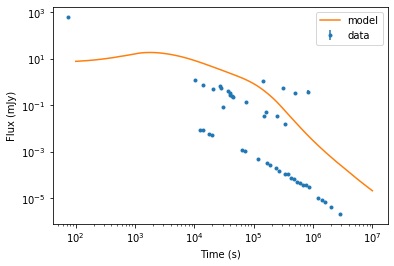

In [15]:
# Times and Frequencies for the model
t = np.geomspace(1.0e2, 1.0e7, 100)

nuO = np.empty(t.shape)
nuO[:] = 4.67706708e+14

# Parameters for the model
Z = {'jetType': grb.jet.TopHat,  # type of jet structure
     'specType': 0,              # type of spectrum
     'thetaObs': 0.0,   # observer angle (radians)
     'E0': 1.0e53,      # isotropic energy (erg)
     'thetaCore': 0.1,  # jet opening angle (radians)
     'n0': 1.0,         # ambient ISM density (cm^{-3})
     'p': 2.5,          # electron energy slope (no units)
     'epsilon_e': 0.1,  # fraction of energy in accelerated electrons (no units)
     'epsilon_B': 0.01, # fraction of energy in magnetic field (no units)
     'ksiN': 1.0,       # fraction of electrons that get accelerated (no units)
     'dL': 1.0e28,      # luminosity distance (cm)
     'z': 0.5           # redshift (no units)
    } 

# Calculate the model!
FnuO = grb.fluxDensity(t, nuO, **Z)  # the model, theoretical prediction

# Plot the data
plt.errorbar(t_data, Fnu_data, Ferr_data, ls='', marker='.', label='data')

# Plot the model
plt.plot(t, Fnu, label='model')

# Scale the Axes
plt.xscale('log')
plt.yscale('log')

# Add a legend
plt.legend()

# Add some labels
plt.xlabel('Time (s)')
plt.ylabel('Flux (mJy)')
plt.show()

NameError: name 'tR' is not defined